<h1 style="text-align: center;">
<span style= 'color : #f31567'> Analytic Model for Light Yield Estimation version 2.0 </span> 
<!-- <span style= 'color : #f31567'> Analytic Model for Estimating Light Collection Efficiency Version 2.0 </span>  -->
</h1>
<hr>
<br>
<p style='color : #FFAA00;  font-size: 16pt; font-family:courier;'>
    Note:
<span style= 'color : silver; text-align: center; '> 1. It has the provision to include 1.) the Rayleigh scattering and absorption and 2.) additional terms if SiPM was covered with WLS 
    <br>
   2. We'll need to remove cells from earlier notebook as msot of the work is being re-writtem to segreto conventions.
         </span> 
<p>
<br>

</p>
<span style = 'color:tomato'> 
    Relevant Documentation: 
<a href="https://www.overleaf.com/read/vpkvkgpfqwst">https://www.overleaf.com/read/vpkvkgpfqwst</a>
    
</span>
</p>


$$
LCE = \frac{X}{1-(s+w)} 
$$
<br>
$$ LCE = \frac{f_{sen}FF_{sys}(1-R)}{1-( f_{sen}R + (1-f_{sen})R_{wall} )} $$
<br>

<p style= "text-align: center;">
<br>
 <p style= "text-align: center;">
<span style = 'color:tomato;'> 
    Relevant Documentations: 
<a href="https://arxiv.org/pdf/1110.6370.pdf">Segreto 2012</a>    
</span>
<p style= "text-align: center;">
<br>
<span style = 'color:tomato'> 
    Research Notes: 
<a href="https://docs.google.com/document/d/1k-8OMUld0fGFGO-Om6wp_pJkQwOL-QxgrfYoKsZIPF4/edit">Google Docs link </a>
    
</span>
</p>

In [1]:
# %matplotlib qt
# %matplotlib inline

from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
# %matplotlib qt  

<h3 style = 'color: #66AAEE '> Project Directory
</h3>

In [2]:
### define project directory
project_dir = r'C:\Users\sarth\projects\LY_Analytic_Model'; 

<h2 style= 'text-align: center;'>
    <span style  = 'color: gold'> Wavelength integrated LY with Absorbtion and Rayleigh Scattering effects</span>
</h2>

In [3]:
### This notebook is being written to implement Segreto model which including Rayleigh Scattering and absorption effects. This section does that.
### Note: Changing few terms to be compliant with Segreto's paper.
#
#
#
#
#
#
#
### one important thing to note is that current modification only work when there is no WLS coating on the Photon Detection Device,i.e, SiPM
### will add additional terms later for case when wven SiPM are covered with WLS.
### function to calculate Function F(Q, ...) 
### basically we have to modify this expression to use Q factor

<h3 style = 'color: DeepPink '> calculating $Q$ factor
</h3>

In [4]:
from sympy import Symbol, exp, integrate

x = Symbol('x')

## L_char is basically what L tilde is in segreto paper

## lambda_eff is basically lambda tilde in segreto paper

def calc_lambda_eff(lambda_abs, lambda_R):
    ''' Calculates effective lambda for Rayleigh scattering and Absorption.'''
    return (lambda_R*lambda_abs)/(lambda_R + lambda_abs)

def P_func(L_char, lambda_eff):
    ''' 
    P_func: P(x) is the probability distribution of the distances that a photon would travel in absence of interactions (between two reflections or between a reflection and absorption/detection).
    The P_func can be changed later if it is felt that we need a different probability distribution function. 
    '''
    return 1/(L_char)

def calc_URA(L_char, lambda_eff, Prob_distr):
    return integrate( Prob_distr*exp(-x/lambda_eff), (x, 0, L_char))

def calc_Q( L_char,  lambda_abs, lambda_R):
    ''' 
    This function is used to compute Q factor for both visible and VUV photons.
    Note:
    We'll call calc_URA since URA is wavelength dependent. We'll also make a call to P_func so for the same reason.
    '''
    lambda_eff = calc_lambda_eff(lambda_abs, lambda_R)
    
    Pdf = P_func(L_char, lambda_eff); # Probability distribution function
    
    URA_value = float(calc_URA(L_char, lambda_eff, Pdf));
    
    return (1-(1-URA_value)*lambda_eff/lambda_R)/(URA_value)

<h3 style = 'color:DeepPink';> plotting $\lambda_R$ vs $Q$ for comparison with segreto paper
</h3>

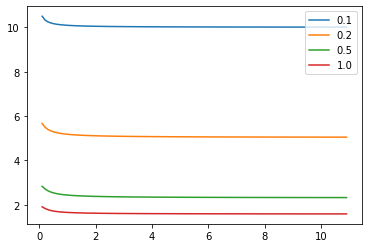

In [5]:
# import numpy as np
# import matplotlib.pyplot as plt
%matplotlib inline

lambda_R = np.arange(0,11, 0.1)

Q_1 = [calc_Q(L_char=1, lambda_abs=0.1, lambda_R = scat) for scat in lambda_R];

Q_2 = [calc_Q(L_char=1, lambda_abs=0.2, lambda_R = scat) for scat in lambda_R];

Q_3 = [calc_Q(L_char=1, lambda_abs=0.5, lambda_R = scat) for scat in lambda_R];

Q_4 = [calc_Q(L_char=1, lambda_abs=1.0, lambda_R = scat) for scat in lambda_R];

plt.figure()
plt.plot( lambda_R, Q_1, label = '0.1')
plt.plot( lambda_R, Q_2, label = '0.2')
plt.plot( lambda_R, Q_3, label = '0.5')
plt.plot( lambda_R, Q_4, label = '1.0')
plt.legend()

In [6]:
# Q_vis = calc_Q(L_char=100, lambda_abs=50, lambda_R=25);

# Q_vuv = calc_Q(L_char=100, lambda_abs=75, lambda_R=50);

<h3 style = 'color:DeepPink;'>  Calculating $F $
</h3>

<p style = 'color:red;'> Note:
<span style = 'color:yellow;'>Define $F$ in such way that we can use same function for computations for any wavelength. This will be useful later when we integrate over all wavelengths and then we can just call F.
    </span>
</p>

<span style = 'color : lime;'>

$$ F( Q, f_{sen}FF_{sys}(1-R), f_{sen}R + (1-f_{sen} )R_{wall} ) = \frac{f_{sen}FF_{sys}(1-\color{Red}R)}{\color{Red}Q-( f_{sen}\color{Red}R + (1-f_{sen})\color{Red}{R_{wall}} )} $$

</span>

<span style = 'color : lime;'>

$$ F(Q,X, s + w) = \frac{X}{Q-(s+w)} $$

</span>

In [7]:
### to be implemnted
### Skeleton only
def calc_F(Q_value, R, R_wall, f_sen, FF_Sys[, wavelength_value]):
    
    '''
    Q, R, R_wall are all wavelength dependent.
    I'll have to find a way to calculate these for specifcic wavelengths.
    '''
    Q_value = calc_Q( L_char,  lambda_abs, lambda_R) ## change this line; drop this idea, implement sequences instead.
    ## similar lines for R and R_wall
    ## How did we do this in earlier notebook version ?
    return (f_sen*FF_sys*(1-R))/(Q_value - (f_sen*R + (1-f_sen)*R_wall) )

SyntaxError: invalid syntax (Temp/ipykernel_6152/3954845935.py, line 3)

<h3 style = 'color: DeepPink '> calculating Light Collection Efficiency, $LCE$
</h3>


<span style = 'color:lime; font-size:12pt;'> 
    $$
    LCE = \frac{(1-f_{sen})*\epsilon_{wls}*\color{Red}{F(Q_{vis}, X, s+w)}}{Q_{VUV}}
    $$
</span>

In [ ]:
### to be implemnted
### Skeleton only
### write a function which calls thses functions, calc_Q, calc_F, and use these to calculate for LCE
def calc_LCE( L_char,  lambda_abs_vuv, lambda_R_vuv, lambda_abs_vis, lambda_R_vis, f_sen, wls_eff, ):
    Q_vuv = calc_Q( L_char, lambda_abs_vuv, lambda_R_vuv); ### no single visible wavelength
    Q_vis_lambda = calc_Q( L_char, lambda_abs_vis, lambda_R_vis);
    return 

In [ ]:
### write functions for interpolation of the measured data values e.g., PDE, E_{WLS} and produce smooth values
### need to calculate lambda R and lambda abs for separate wavelengths as well
### to be implemented

<!-- <h3 style = 'color: DeepPink '> calculating Light Yield, $LY$
</h3> -->

In [ ]:
### to be implemnted
### Skeleton code only
# SY = 40; ### find a better place to keep these values
# PDE = ## change this line
# def calc_LY():
#     LCE_value = calc_LCE()
#     return SY*LCE_value*PDE_value

<h3 style = 'color: DeepPink; text-align:center; font-size:16pt; '> 🍕 integrate Light Yield
</h3>
<!-- <p>
Previously known as Weighted Average of Light Yield 
</p> -->

<!-- <p> 
<span style = 'color : #5EA9E5;'> 
<br>
% $$
% integrate\_LY = \frac{\sum( [LY\_value(\color{red}{PDE(\lambda)}, f_{sen}, FF_{sys}, \color{red}{R(\lambda)}, \color{red}{R_{wall}(\lambda)}, \color{red}{Q(\lambda)}, \epsilon_{wls} ) ] * \color{red}{E_{wls}(\lambda)})}{\sum \color{red}{E_{wls}(\lambda)}}
% $$
</span>
<br>
<br>
<br>
</p> -->

<p> 
<span style = 'color : lime; font-size:14pt;'> 
<br>
<br>
$$
integrate\_LY = \frac{SY* \sum( [calc\_LCE(f_{sen}, FF_{sys}, \color{red}{R(\lambda)}, \color{red}{R_{wall}(\lambda)}, \color{red}{Q(\lambda)}, \epsilon_{wls}) ] * [ \color{red}{PDE(\lambda)} ] * [ \color{red}{E_{wls}(\lambda)} ] ) } {\sum \color{red}{E_{wls}(\lambda)}}
$$
</span>
<br>
<br>
<span style= ' font-size:14pt; text-align: left; color:white;'>
PS: Red --> wavelength dependent
</span>
</p>

In [94]:
### to be implemnted
def integrate_LY( wavelength_range, WLS_emission_spectrum, PDE, f_sen, FF_sys, R, R_wall, SY=40):
    #     wavelength_value or index?
    '''
    acceptable format for wavelength_range is [begining, end, step]
    𝜖_𝑤𝑙𝑠 represents the wavelength shifting efficiency of the WaveLength Shifter
    '''
    load_SiPM reflectance # skeleton code
    wavelength_vector = np.arange(wavelength_range[0], wavelength_range[1], wavelength_range[2]) ;
    numerator_value = 0 ;
    denominator_value = 0 ;
    
    ### call smoothening fucntion here        
    R_SiPM_smooth = make_smooth(R_SiPM)
    R_Wall_PEN_smooth = make_smooth(R_Wall_PEN)
    R_Wall_TPB_smooth = make_smooth(R_Wall_TPB)
    PDE_smooth = make_smooth(PDE)
    E_PEN_smooth = make_smooth(E_PEN)
    E_TPB_smooth = make_smooth(E_TPB)
    
    for wavelength_index in range(len(wavelength_vector)):
        wavelength_value = wavelength_vector[wavelength_index]
        numerator_value += calc_LCE(wavelength_index, ) * PDE(wavelength_index) * WLS_emission_spectrum(wavelength_index);
#         denominator_value += wavelength_value
    denominator_value = sum(wavelength_vector)
    return SY*numerator_value/denominator_value

SyntaxError: invalid syntax (Temp/ipykernel_6152/2810911150.py, line 8)

In [ ]:
# final_LY_value = integrate_LY([366, 560, 0.5], ) 
### A function should be such that we only need to provide values here and nowhere else
###  ofcourse data files still need to be specified

<h2 style = 'color:#66AAEE; font-size: 20pt; text-align: center;'>
    Data 
</h2>

<p style ='color: silver; font-size: 14pt'> project directory already defined at the top
</p>
<p style ='color: silver; font-size: 14pt'>PS:  The preprocessing is different for each file depending on data structure.
</p>

<h3 style = 'text-align: left'>
    <span style = "color : slateblue"> SiPM Reflectance data </span>
</h3>
<!-- <p>
    SiPM Reflectance .dat file provided by Cenk
    <br>
    <span style = 'color: #FF6611; font-size: 18px'> Note: </span> 
    SiPM Reflectance is multiplied by 0.91 to take care of the effect of antireflective coating in Liquid Argon chamber (needs further investigtation)
</p> -->

In [8]:
R_SiPM_df = pd.read_csv(path.join(project_dir, 'Data','sipm_hr1_processed.txt'), sep = '\t')  ## 'Data' is the name of the folder containing Data files
R_SiPM = R_SiPM_df.copy()
R_SiPM['R'] = [int(value)/100 for value in R_SiPM_df['R']]

## cenk's data files for darkside veto are given below

# cenk_SiPM_R_df = pd.read_csv(path.join(project_dir, 'Data','SiPM_ref.csv'), sep = ',')
# # cenk_SiPM_R_values = cenk_SiPM_R_vector.copy()
# # cenk_R_SiPM_values['R'] = [int(value)/100 for value in cenk_R_SiPM_vector['R']]
# cenk_SiPM_R_df2 = cenk_SiPM_R_df.copy()
# cenk_SiPM_R_df2['LAr_equivalent_Reflectance'] = cenk_SiPM_R_df2['R']*0.91 

# ### Note: SiPM is coated with an unknown anti-reflection coating
# ### 0.91 : To get the unknown reflectivity of SiPM in Liquid Argon. Since SiPM is also coated with an anti reflection coating, getting the equivalent 
# ### reflectance is not straight forward. 0.91 is based on an educated guess.

# cenk_SiPM_R_df2['wavelength'] = 1239.847/cenk_SiPM_R_df2['E'] # Eneergy unit eV wavlength Unit: nm
# # SiPM_ref.dat
# # cenk_SiPM_R_df3 = cenk_SiPM_R_df2.sort_values(by = 'wavelength')

In [9]:
# cenk_SiPM_R_df2.head()

In [10]:
# plt.figure()
# plt.plot(cenk_SiPM_R_df2['wavelength'], cenk_SiPM_R_df2['R'])
# plt.plot(SiPM_R_values['Wavelength'], SiPM_R_values['R'])

<h3 style = 'text-align: left'>
    <span style = "color : slateblue"> SiPM PDE data </span>
</h3>
<p>
    Using FBK PDE values
<br>
    Normalizing with 40/52.77
</p>

In [11]:
### FBK Values sent by cenk
# photon_wavelegnth = [285.87, 301.14, 320.99, 340.83, 365.26, 380.53, 391.22, 400.38, 411.06, 420.22, 435.49, 449.23, 464.50, 499.61, 588.16, 698.09]
# PDE_vector = [18.39, 37.24, 41.87, 42.43, 45.03, 48.12, 52.72, 52.75, 52.77, 52.29, 48.77, 46.26, 40.71, 38.76, 28.82, 18.93] # %age values
# PDE_normalized_vector = []
### Normalizing PDE values in FBK data as instructed by Cenk
# PDE_normalized_vector = [value*40/max(PDE_vector) for value in PDE_vector]
## PDE_normalized_vector
# norm_PDE_values = [value/100 for value in PDE_normalized_vector]

### LFoundry PDE Values sent by Cenk
photon_wavelegnth = [365.39, 390.34, 399.89, 409.98, 420.06, 434.93, 450.32, 500.21, 525.16, 545.33, 590.98, 630.25, 700.32]
PDE_vector = [43.277, 51.892, 54.257, 52.399, 50.709, 46.993, 42.601, 36.014, 30.439, 28.581, 24.358, 20.473, 15.574]
# Normalization for PDE values 
norm_PDE_values = [value/100 for value in PDE_vector]


frame = {'photon_wavelegnth':photon_wavelegnth, 'PDE_norm': norm_PDE_values}

PDE = pd.DataFrame(frame)

# max(PDE['PDE_norm'])

<h3 style= 'color: slateblue'>
   PEN Reflectance Data 
</h3>
<p>
<span style= 'color: red; font-size : 22px'>  Needs verification !!! 
</span>
</p>

In [12]:
## R_wall_PEN = 
PEN_photon_energy = [0.1, 2.067,2.175,2.214,2.255,2.340,2.385,2.431,2.436,2.531,2.583,2.638,2.696,2.725,2.756,2.787,2.818,
2.884,2.918,2.952,2.988,3.024,3.039,3.047,3.054,3.062,3.069,3.077,3.085,3.092,3.100,3.108,3.116,3.123,3.131,3.139,3.147,3.155,
3.163,3.171,3.179,3.188,3.196,3.204,3.212,3.221,3.263, 8.0] ## energy in eV

PEN_reflectance = [100.130, 100.130,99.995,99.856,99.681,99.659,99.569,99.351,99.306,99.018,98.652,98.415,98.283,
98.018,97.856,97.606,97.457,97.134,96.928,96.827,96.247,95.737,95.359,95.197,95.048,94.876,94.684,94.463,94.055,93.650,93.147,
92.562,91.812,90.904,89.807,88.506,86.957,85.242,83.156,80.678,77.811,74.615,71.004,67.089,62.924,58.670,20.000, 20.000] ## %age reflectance

PEN_reflectance = [reflectance*0.98/100 for reflectance in PEN_reflectance] 
# PEN_reflectance = [reflectance*0.98*0.994/100 for reflectance in PEN_reflectance] 

### Reflectance is multiplied by 0.98 and 0.994 for calibration purpose:
    ### 1. 0.98 is the reflectance of Basrium Sulphate used as the standard in photo spectrometer
    ### 2. The second factor is specific to 2PAC. 0.994 is the coverage fraction of Wavelength Shifting material (a small surface coverage is lost to holes, bolts etc in 2PAC)
### The calculation is very senstitive to Reflectance


PEN_photon_wavelength = []

for PEN_energy_value in PEN_photon_energy:
    PEN_wavelengthg_length = 1239.847/PEN_energy_value
    PEN_photon_wavelength.append(PEN_wavelengthg_length)

frame = {'photon_wavelength': PEN_photon_wavelength,
        'PEN_reflectance': PEN_reflectance}

R_Wall_PEN = pd.DataFrame(frame)

## reverse the order of wavelength smaller to bigger
R_Wall_PEN = R_Wall_PEN.iloc[::-1]

# R_Wall_PEN

<h3> <span style = "color : slateblue"> PEN Emission Spectrum </span> </h3>

In [13]:
# r_PEN = r'D:\D Downloads\Current_work\pen-tess.txt'
r_PEN = path.join(project_dir, 'Data', 'pen-tess.txt')
emission_spectrum_PEN = pd.read_csv(r_PEN, sep ='\t')

E_PEN = emission_spectrum_PEN.drop(['a','b','c'], axis=1)

# E_PEN

# normalize : divide by maximum value
E_PEN['efficiency'] = E_PEN['efficiency']/max(E_PEN['efficiency'] ) 

# remove negative values
E_PEN = E_PEN[E_PEN > 0].dropna()
# E_PEN['efficiency']
## What are the units of efficiency? Normalize PEN Spectrum ??
## Remove negative values?
## Need linear interpolation for everyuthing R, R_Wall, PDE and emission spectrum

<h3 style = 'color : slateblue'> TPB Reflectance data 
</h3>

In [14]:
photon_energy = [0.1, 2.067,2.175,2.214,2.255,2.340,2.385,2.431,2.436,2.531,2.583,2.638,2.696,2.725,2.756,2.787,2.818,2.884,2.918,2.952,2.988,3.024, 3.221,3.263, 8.0]
TPB_reflectance = [98.936,98.936,99.180,99.309,99.375,99.392,99.534,99.490,99.491,99.685,99.635,99.593,99.541,99.457,99.380,99.374,99.196,98.924,98.521,97.653,95.581,92.569,13.0,3.0,3.0]

photon_wavelength = []

TPB_reflectance = [reflectance*0.98/100 for reflectance in TPB_reflectance]
# TPB_reflectance = [reflectance*0.98*0.994/100 for reflectance in TPB_reflectance]

### Reflectance is multiplied by 0.98 and 0.994 for calibration purpose:
    ### 1. 0.98 is the reflectance of Basrium Sulphate used as the standard in photo spectrometer
    ### 2. The second factor is specific to 2PAC. 0.994 is the coverage fraction of Wavelength Shifting material (a small surface coverage is lost to holes, bolts etc in 2PAC)
### The calculation is very senstitive to Reflectance

for energy_ in photon_energy:
    length_ = 1239.847/energy_
    photon_wavelength.append(length_)

frame = {'photon_wavelength': photon_wavelength,
        'TPB_reflectance': TPB_reflectance}

R_Wall_TPB = pd.DataFrame(frame)

## reverse the order of wavelength smaller to bigger
R_Wall_TPB = R_Wall_TPB.iloc[::-1]

# R_Wall_TPB

<h3 style = "color : slateblue"> TPB Emission Spectrum </h3>

In [15]:
#### why do we have negative values?
#### Might need to clean data
## drop negative values
## normalize efficiency

# r_TPB = r'D:\D Downloads\Current_work\tpb-fran.txt'
r_TPB = path.join(project_dir, 'Data','tpb-fran.txt')
emission_spectrum_TPB = pd.read_csv(r_TPB, sep ='\t')

E_TPB = emission_spectrum_TPB.drop(['a','b','c','d'], axis=1)
# E_TPB

<p> <span style = "font-size: 18pt; color: Red"> Warning: </span> TPB data has negative values!!! </p>

In [16]:
# normalize : divide by maximum value
E_TPB['efficiency'] = E_TPB['efficiency']/max(E_TPB['efficiency'] ) 
# remove negative values
E_TPB = E_TPB[E_TPB > 0].dropna()

# E_TPB


In [17]:
# smoothing

In [110]:
f_R_Wall_TPB = interp1d(R_Wall_TPB['photon_wavelength'], R_Wall_TPB['TPB_reflectance'])
cenk_R_Wall_TPB_uniform = f_R_Wall_TPB(wavelength_vector)

f_R_Wall_PEN = interp1d(R_Wall_PEN['photon_wavelength'], R_Wall_PEN['PEN_reflectance'])
cenk_R_Wall_PEN_uniform = f_R_Wall_PEN(wavelength_vector)

f_E_PEN = interp1d(E_PEN['wavelength'], E_PEN['efficiency'])
E_PEN_uniform = f_E_PEN(wavelength_vector)

f_E_TPB = interp1d(E_TPB['wavelength'], E_TPB['efficiency'])
E_TPB_uniform = f_E_TPB(wavelength_vector)

f_PDE = interp1d(PDE['photon_wavelegnth'], PDE['PDE_norm'])
cenk_PDE_uniform = f_PDE(wavelength_vector)

# f_cenk_SiPM_R = interp1d(cenk_SiPM_R_df2['wavelength'], cenk_SiPM_R_df2['LAr_equivalent_Reflectance'])
# cenk_SiPM_R_uniform = f_cenk_SiPM_R(wavelength_vector)

In [97]:
### variable name 'photon_wavelegnth' is NOT hard coded for all the data frames.
def make_smooth(data_frame_var):
    name_column_0 = data_frame_var.columns[0]
    name_column_1 = data_frame_var.columns[1]
    
    photon_wavelength = data_frame_var[name_column_0]
    physical_quantity = data_frame_var[name_column_1]
    
    interpol_func = interp1d(photon_wavelength , physical_quantity)
    return  interpol_func(wavelength_vector)

In [96]:
# wavelength_vector = np.arange(366, 560, 0.5) 

In [103]:
R_SiPM_smooth = make_smooth(R_SiPM)

R_Wall_PEN_smooth = make_smooth(R_Wall_PEN)

R_Wall_TPB_smooth = make_smooth(R_Wall_TPB)

PDE_smooth = make_smooth(PDE)

E_PEN_smooth = make_smooth(E_PEN)

E_TPB_smooth = make_smooth(E_TPB)